In [1]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
import json
import pandas as pd
import os

import yaml
import hashlib

In [2]:
output_dir = '/Users/kumiori3/Documents/WIP/Nature/paper_IJTCAM/technology/fig'

In [242]:
class SymbolicDiscreteDamage:
    def __init__(self, matpar, N = 1, 
                 name = "discrete generalised damage",
                 slug = "general damage"):
        self.matpar = matpar
        self.state = self.get_state(N)
        self.str = name
        self.slug = slug

    def get_state(self, N):
        
        u = sp.symbols([f"u{i}" for i in range(0, N)])
        e = sp.symbols([f"e{i}" for i in range(1, N+1)])
        α = sp.symbols([f"α{i}" for i in range(1, N+1)])

        state = {"u": u, "α": α, "e": e}
        return state
        
    def _s(self, α):
        s = sp.Function('s')
        return s(α)

    def _a(self, α):
        γ = self.matpar["γ"]
        a = sp.Function('a')
        return a(α)
    
    def energy(self):
        """Total energy"""
        state = self.state
        N = sp.symbols("N")
        return self._elastic() + self._damage() - self.work()

    def work(self):
        return 0

    def _elastic(self):
        state = self.state
        e = state["e"]
        α = state["α"]

        _E0 = self.matpar["E0"]
        _N = self.matpar["N"]
    
        return 1/_N * sum([1./2. * _E0 * self._a(α[i]) * e[i]**2 for i in range(len(α))])

    def _w(self, αi):
        w = sp.Function('w')

        return w(αi)

    def _damage(self):
        state = self.state
        _α = state["α"]
        _w1 = self.matpar["w1"]

        _N = self.matpar["N"]

        return 1/_N * sum([_w1 * self._w(_α[i]) for i in range(len(_α))])


    # Explicit expressions
    def w(self, αi):
        return αi

    def boundary_condition(self):
        t = sp.symbols('t')
        N = sp.symbols("N")
        L = sp.symbols("L")
        
        return t*N/L       

    def a(self, αi):
        γ = self.matpar["γ"]

        return (1 - self._w(αi)) / ((γ-1) * self._w(αi) + 1)

    def s(self, αi):

        return 1. / self.a(αi)

    def aprime(self):
        return sp.diff(self.a(sp.symbols('α')), sp.symbols('α')) \
                    .replace(sp.Function('a'), self.a) \
                    .replace(sp.Function('w'), self.w) \
                    .doit()
                    
    def wprime(self):
        return sp.diff(self.w(sp.symbols('α')), sp.symbols('α')) \
                .replace(sp.Function('w'), self.w) \
                .doit()

    def __str__(self):
     return self.str


In [270]:
class ModelAnalysis:
    """Helper class to analyse (stability) properties of a model"""

    def __str__(self):
        return self.model.slug

    def __init__(self, model):
        self.model = model
        self.state = model.state
        self.matpar = model.matpar

        _β = sp.symbols("β")
        _e = sp.symbols("e")
        self._β = _β
        self._e = _e

        self._s = model._s(_β)
        self._sp = sp.diff(self._s, _β, 1)
        self._spp = sp.diff(self._s, _β, 2)

        self._a = model._a(_β)
        self._ap = sp.diff(self._a, _β, 1)
        self._app = sp.diff(self._a, _β, 2)

        self._w = model._w(_β)
        self._wp = sp.diff(self._w, _β)
        self._wpp = sp.diff(self._w, _β, 2)

        self.criterion()

    def plot_material(self, _matpar):
        _damage = np.linspace(0.0, 1.0)
        alpha = sp.symbols("α")

        _a = self.model.a(alpha).replace(sp.Function("w"), self.model.w)
        _a_prime = sp.diff(_a, alpha)
        _a_prime_prime = sp.diff(_a, alpha, 2)

        _s = self.model.s(alpha).replace(sp.Function("w"), self.model.w)
        _s_prime = sp.diff(_s, alpha)
        _s_prime_prime = sp.diff(_s, alpha, 2)

        _wf = sp.lambdify(alpha, self.model.w(alpha).subs(_matpar), "numpy")

        _af = _af = sp.lambdify(alpha, _a.subs(_matpar), "numpy")
        _apf = sp.lambdify(alpha, _a_prime.subs(_matpar), "numpy")
        _appf = sp.lambdify(alpha, _a_prime_prime.subs(_matpar), "numpy")

        _sf = sp.lambdify(alpha, _s.subs(_matpar), "numpy")
        _spf = sp.lambdify(alpha, _s_prime.subs(_matpar), "numpy")
        _sppf = sp.lambdify(alpha, _s_prime_prime.subs(_matpar), "numpy")

        # Plots
        figure, axis = plt.subplots(1, 2, figsize=(8, 6))
        _ax = axis[0]
        _ax.axhline(0, c="k")
        _ax.plot(_damage, [_af(t) for t in _damage], label="a")
        _ax.legend(loc=2)
        _ax.plot(_damage, [_apf(t) for t in _damage], label="a'", c="r")
        _ax.plot(_damage, [_appf(t) for t in _damage], label="a''")
        _ax2 = _ax.twiny()
        _ax2.plot(_damage, [_wf(t) for t in _damage], label="w", c="k", ls="dashed")

        _ax.set_xlim(0, 1)
        _ax2.set_xlim(0, 1)
        _ax.legend()
        _ax2.legend(loc=3)

        _ax = axis[1]

        _ax.plot(_damage, [_sf(t) for t in _damage], label="s")
        _ax.legend(loc=2)
        _ax.axhline(0, c="k")
        _ax.twinx()
        _ax.plot(_damage, [_spf(t) for t in _damage], label="s'")
        _ax.plot(_damage, [_sppf(t) for t in _damage], label="s''")
        _ax.set_xlim(0, 1)
        _ax.set_ylim(0, 10)
        _ax.legend(loc=1)
        figure.suptitle(f"Behaviour of {self.model.__str__()} is Material")

        return figure, axis

    def _equilirbrium_e(self):
        state = self.state
        t, L, N = sp.symbols("t L N")
        _S = sum([self.model._s(αi) for αi in state["α"]])

        datum = self.model.boundary_condition()

        _e = [(datum * self.model._s(αi) / _S).simplify() for αi in state["α"]]

        return _e

    def _elastic_energy_fc_alpha(self):
        _ei = self._equilirbrium_e()
        state = self.state
        equilibrium_subs = {v[0]: v[1] for v in zip(state["e"], _ei)}
        subs_s_inverse = {
            sp.Function("a")(sp.Symbol(a.name)): 1 / self.model._s(a)
            for a in state["α"]
        }

        return (
            self.model._elastic()
            .subs(equilibrium_subs)
            .subs(subs_s_inverse)
            .simplify()
        )
        
    def get_state(self, matpar):
        return self.model.state

    def _state_split(self, m, matpar):
        """Split the state into homogeneous and bifurcated parts"""
        state = self.state
        assert m < matpar[N]

        _bif_α = [state["α"][k + 1] for k in range(m)]
        _bif_e = [state["e"][k + 1] for k in range(m)]

        _homo_α = set(state["α"]) - set(_bif_α)
        _homo_e = set(state["e"]) - set(_bif_e)

        return _bif_α, _homo_α, _bif_e, _homo_e

    def _state_homog_substitutions(self):
        """Substitutions for the homogeneous state"""
        state = self.state
        αt = sp.symbols("α_t")
        et = sp.symbols("e_t")

        _subs_αh = {a: αt for a in state["α"]}
        _subs_eh = {e: et for e in state["e"]}

        return _subs_αh, _subs_eh

    def _state_bifurcation_substitutions(self, m, state, matpar):
        """Computes substitutions for bifurcated states"""

        assert m < matpar[N]
        _bif, _homo, _bif_e, _homo_e = self._state_split(m, state, matpar)
        _αb = sp.symbols("α_t")
        _eb = sp.symbols("e_t")
        αt = sp.symbols("α^*")
        et = sp.symbols("e^*")

        _subs_αb = {a: _αb for a in _bif}
        _subs_eb = {e: _eb for e in _bif_e}

        _subs_αt = {a: αt for a in _homo}
        _subs_et = {e: et for e in _homo_e}

        return {**_subs_αb, **_subs_αt}, {**_subs_eb, **_subs_et}

    def criterion(self):
        """Damage onset"""
        model, state = self.model, self.state
        x = sp.symbols("x")
        t, L, N = sp.symbols("t L N")

        _e0 = t / L

        _homogeneous_damage, _homogeneous_strain = self._state_homog_substitutions()

        _crit = sp.diff(
            model.energy().subs(_homogeneous_damage).subs(_homogeneous_strain), 
            sp.symbols('α_t')
        ).subs({sp.symbols('e_t'): _e0, sp.symbols('α_t'): 0})

        self.crit = _crit

        return self.crit.simplify()

    def critical_load(self, matpar={}):
        """Critical load"""
        _a = sp.Function("a")
        _w = sp.Function("w")
        t = sp.symbols("t")

        criterion = self.crit.replace(_a, self.model.a).replace(_w, self.model.w).simplify()

        tc = sp.solve(criterion, t)

        if matpar:
            tc = [_tc.subs(matpar) for _tc in tc if _tc.subs(matpar).is_positive]

        return tc, criterion

    def energy_fc_alpha(self):
        _ei = self._equilirbrium_e()
        state = self.state
        equilibrium_subs = {v[0]: v[1] for v in zip(state["e"], _ei)}
        subs_s_inverse = {
            sp.Function("a")(sp.Symbol(a.name)): 1 / self.model._s(a)
            for a in state["α"]
        }

        return (
            self.model.energy()
            .subs(equilibrium_subs)
            .subs(subs_s_inverse)
            .simplify()
        )

    def homogeneous_α(self, state, matpar={}):
        """Solves the (homogeneous) evolution law for damage"""
        αt = sp.symbols("α_t")
        state = self.state

        if matpar:
            return [
                sol.subs(matpar)
                for sol in list(
                    map(sp.simplify, sp.solve(self.evo_α(state, matpar), αt))
                )
            ]
        else:
            return list(map(sp.simplify, sp.solve(self.evo_α(state), αt)))

    def homogeneous_damage(self, state, matpar={}):
        idx = self.positive_solution_wrt_t(matpar)
        _alpha = self.homogeneous_α(matpar)[idx].subs(matpar)
        tc = self.critical_load(matpar)[0][0]
        t = sp.symbols("t")

        # tc = self.critical_load(matpar)
        alpha = sp.Piecewise((_alpha, t >= tc), (0, t < tc))

        return alpha


    def evo_α(self, state, matpar={}):
        """Evolution law for damage"""
        αt = sp.symbols("α_t")
        _a = sp.Function("a")
        # _w = sp.Function('w')

        subs_homog_α, _ = self._state_homog_substitutions()

        energy = (
            self.energy_fc_alpha()
            .subs(subs_homog_α)
            .replace(sp.Function("s"), self.model.s)
            .replace(sp.Function("w"), self.model.w)
            .doit()
        )

        if matpar:
            energy = energy.subs(matpar)

        return sp.diff(energy, αt).simplify()

    def positive_solution_wrt_t(self, _matpar={}):
        idx = np.where(
            np.array(
                [
                    sp.diff(eq, sp.symbols("t")).subs(_matpar)
                    for eq in self.homogeneous_α(_matpar)
                ]
            )
            > 0
        )[0]
        return idx[0]

    def _elastic_energy_m_bifurcations(self, m):
        n = len(self.state["α"])
        # n = N
        N = sp.symbols("N")
        # _s = model.model.s
        _s = sp.Function("s")

        at = sp.symbols("α_t")
        ax = sp.symbols("α^*")
        return 1.0 / 2.0 * E0 * (N * t / L) ** 2 * 1 / ((N - m) * _s(ax) + m * _s(at))

    def _diff_energy_m_bifurcations(self, m):
        n = len(self.state["α"])
        n = N
        # _s = model.model.s
        _s = sp.Function("s")

        at = sp.symbols("α_t")
        ax = sp.symbols("α^*")
        return (
            -1.0
            / 2.0
            * E0
            * (N * t / L) ** 2
            * m
            * sp.diff(_s(at), at)
            / ((n - m) * _s(ax) + m * _s(at)) ** 2
        )

    def xi_elastic_energy_m_bifurcations(self):
        n = len(self.state["α"])
        N = sp.symbols('N')
        _s = sp.Function('s')
        
        at = sp.symbols('α_t')
        ax = sp.symbols('α^*')
        xi = sp.symbols('xi')
        
        return 1./2. * E0 * (t / L)**2 * 1 / (_s(ax) + (xi)*(_s(at)-_s(ax)))
        
    def xi_energy_m_bifurcations(self):
        n = len(self.state["α"])
        at = sp.symbols('α_t')
        ax = sp.symbols('α^*')
        N = sp.symbols('N')
        xi = sp.symbols('xi')
        
        return self.xi_elastic_energy_m_bifurcations() +   \
            self.matpar["w1"] * (xi * self.model.w(at) + (1-xi) * self.model.w(ax))

    def xi_diff_energy_m_bifurcations(self):
        n = len(self.state["α"])
        n = N
        # _s = model.model.s
        _s = sp.Function('s')
        
        at = sp.symbols('α_t')
        ax = sp.symbols('α^*')
        xi = sp.symbols('xi')
        return - 1./2. * E0 * (t / L)**2 * xi * sp.diff(_s(at), at) / ((_s(ax) + (xi)*(_s(at)-_s(ax))))**2 + \
            self.matpar["w1"] * (xi * sp.diff(self.model.w(at), at) ) 

    def energy_m_bifurcations(self, m):
        n = len(self.state["α"])
        at = sp.symbols("α_t")
        ax = sp.symbols("α^*")

        return self._elastic_energy_m_bifurcations() + self.model.matpar["w1"] * (
            m * self.model.w(at) + (n - m) * self.model.w(ax)
        )

In [346]:
N = sp.symbols("N")
t = sp.symbols('t')
_a = sp.Function('a')
_w = sp.Function('w')
γ = sp.symbols('γ')
E0, L, w1, σc = sp.symbols('E0 L w1 σc')

_N = 2
_normalise = {E0: 1, w1: 1, L: 1}

# u = sp.symbols([f"u{i}" for i in range(0, _N)])
# e = sp.symbols([f"e{i}" for i in range(1, _N+1)])
# α = sp.symbols([f"α{i}" for i in range(1, _N+1)])
# state = {"u": u, "α": α, "e": e}

_α = sp.symbols("α")
β = sp.symbols('β')


_matpar = {N: _N, γ: 5, E0: 1, w1: 1, L: 1}
matpar = {"N": N, "γ": γ, "E0": E0, "w1": w1, "L": L}

atls = SymbolicDiscreteDamage(matpar, _N)
model = ModelAnalysis(atls)

model.criterion()


1.0*E0*t**2*Subs(Derivative(a(β), β), β, 0)/(L**2*N) + 2*w1*Subs(Derivative(w(β), β), β, 0)/N

In [347]:
_homogeneous_damage, _homogeneous_strain = model._state_homog_substitutions()
sp.diff(atls.energy().subs(_homogeneous_damage).subs(_homogeneous_strain), 
        sp.symbols('α_t')).simplify()   \
            .subs(sp.symbols('e_t'), t/L) \
            .subs(sp.symbols('α_t'), 0).simplify()


1.0*E0*t**2*Subs(Derivative(a(β), β), β, 0)/(L**2*N) + 2*w1*Subs(Derivative(w(β), β), β, 0)/N

$$
\begin{aligned}
\mathcal E_N (e, \alpha) &=  E_0\sum_{i=0}^N \frac{1}{2}    a(\alpha_i)  e_i^2  + \sum_{i=0}^N {w_1}w(\alpha_i) \\
 \tilde {\mathcal E}_N (u, \alpha) = \frac{1}{N}{\mathcal E}_N (u, \alpha) &= E_0 N\sum_{i=0}^N \frac{1}{2}  a(\alpha_i)  (u_i-u_{i-1})^2  + \frac{w_1}{N} \sum_{i=0}^N w(\alpha_i) 
\end{aligned}
$$

In [348]:
atls.energy()

(w1*w(α1) + w1*w(α2))/N + (0.5*E0*e1**2*a(α1) + 0.5*E0*e2**2*a(α2))/N

In [349]:
model._state_homog_substitutions()

({α1: α_t, α2: α_t}, {e1: e_t, e2: e_t})

In [350]:
atls.energy().subs(model._state_homog_substitutions()[0])

2*w1*w(α_t)/N + (0.5*E0*e1**2*a(α_t) + 0.5*E0*e2**2*a(α_t))/N

In [351]:
ModelAnalysis(atls).criterion()

1.0*E0*t**2*Subs(Derivative(a(β), β), β, 0)/(L**2*N) + 2*w1*Subs(Derivative(w(β), β), β, 0)/N

In [352]:
ModelAnalysis(atls).criterion().simplify()

1.0*E0*t**2*Subs(Derivative(a(β), β), β, 0)/(L**2*N) + 2*w1*Subs(Derivative(w(β), β), β, 0)/N

In [353]:
(ModelAnalysis(atls).criterion()  \
    .replace(_a, model.model.a )    \
    .replace(_w, model.model.w).doit()).simplify()

-1.0*E0*t**2*γ/(L**2*N) + 2*w1/N

In [354]:
atls.a(sp.symbols('α'))

(1 - w(α))/((γ - 1)*w(α) + 1)

In [355]:
atls.a(sp.symbols('α')).replace(sp.Function('w'), atls.w)

(1 - α)/(α*(γ - 1) + 1)

In [356]:
atls.aprime().simplify()

-γ/(α*γ - α + 1)**2

In [357]:
model.critical_load()[0]

[-1.4142135623731*L*sqrt(w1/(E0*γ)), 1.4142135623731*L*sqrt(w1/(E0*γ))]

In [358]:
tc, criterion = model.critical_load(_matpar)
tc

[0.282842712474619*sqrt(5)]

In [359]:
criterion.simplify()

-1.0*E0*t**2*γ/(L**2*N) + 2*w1/N

In [360]:
model._equilirbrium_e()

[N*t*s(α1)/(L*(s(α1) + s(α2))), N*t*s(α2)/(L*(s(α1) + s(α2)))]

In [361]:
_matpar

{N: 2, γ: 5, E0: 1, w1: 1, L: 1}

In [362]:
sum([e**2 for e in model._equilirbrium_e()]).simplify()

N**2*t**2*(s(α1)**2 + s(α2)**2)/(L**2*(s(α1) + s(α2))**2)

In [363]:
model.energy_fc_alpha()

(0.5*E0*N**2*t**2 + L**2*w1*(s(α1) + s(α2))*(w(α1) + w(α2)))/(L**2*N*(s(α1) + s(α2)))

In [364]:
model._elastic_energy_fc_alpha().simplify()

0.5*E0*N*t**2/(L**2*(s(α1) + s(α2)))

In [365]:
subs_homog_α, subs_homog_e =  model._state_homog_substitutions()
subs_homog_α, subs_homog_e

({α1: α_t, α2: α_t}, {e1: e_t, e2: e_t})

In [366]:
subs_homog_α

{α1: α_t, α2: α_t}

In [367]:
sp.diff(model.energy_fc_alpha().subs(subs_homog_α).subs(_normalise).simplify()  \
    .subs(sp.Function('s')(sp.Symbol('α_t')), 1/atls.a(sp.Symbol('α_t'))),
    sp.Symbol('α_t')).simplify().replace(sp.Function('w'), atls.w).doit()
    

-0.25*N*t**2*γ/(α_t*γ - α_t + 1)**2 + 2/N

In [368]:
num, den = sp.fraction(sp.together(_))

In [369]:
(num / (2 * γ)).simplify()

-0.125*N**2*t**2 + (α_t*γ - α_t + 1)**2/γ

In [370]:
sp.solve(num, sp.symbols('α_t'))[1].subs({γ: 2}).subs(_matpar)

0.707106781186548*sqrt(2)*t - 1.0

In [371]:
sp.solve(_, sp.Symbol('α_t'))[1].simplify()

IndexError: list index out of range

In [372]:
num, den = sp.fraction(_)
num.args
(num.args[-1]/den+ num.args[1]/den)

1.4142135623731*sqrt(2)*t

In [373]:
model.energy_fc_alpha().subs(subs_homog_α).simplify()

0.25*E0*N*t**2/(L**2*s(α_t)) + 2*w1*w(α_t)/N

In [374]:
(model.energy_fc_alpha().subs(subs_homog_α)).subs(_matpar).simplify()

0.5*t**2/s(α_t) + w(α_t)

In [375]:
_energy = model.energy_fc_alpha()     \
    .replace(sp.Function('s'), atls.s)      \
        .replace(sp.Function('w'), atls.w)  \
            .subs(subs_homog_α).simplify()    \
                .subs(sp.symbols('N'), _N) \
        .doit().simplify()
# .subs(subs_homog_α).subs(_matpar).simplify()

_energy.subs(_normalise)

(-0.5*t**2*(α_t - 1) + α_t*(α_t*(γ - 1) + 1))/(α_t*(γ - 1) + 1)

In [376]:
model.energy_fc_alpha()
num, den = sp.fraction(model.energy_fc_alpha().subs(_normalise))
_energy = (num.args[0]/den+ num.args[1]/den).subs(subs_homog_α).subs(sp.symbols('N'), _N).simplify() 
_energy

0.5*t**2/s(α_t) + w(α_t)

In [377]:
sp.diff(_energy, sp.symbols('α_t')).simplify()

-0.5*t**2*Derivative(s(α_t), α_t)/s(α_t)**2 + Derivative(w(α_t), α_t)

In [378]:
sp.diff(atls.a(sp.symbols('α')), 
        sp.symbols('α')).doit().simplify()

-γ*Derivative(w(α), α)/(γ*w(α) - w(α) + 1)**2

In [379]:
sp.diff(_energy.replace(sp.Function('s'), atls.s)      \
    .replace(sp.Function('w'), atls.w).doit().simplify(), 
    sp.symbols('α_t')).simplify() 
    

((γ - 1)*(0.5*t**2*(α_t - 1) - α_t*(α_t*(γ - 1) + 1)) + (α_t*(γ - 1) + 1)*(-0.5*t**2 + 2*α_t*(γ - 1) + 1))/(α_t*(γ - 1) + 1)**2

In [380]:
sp.diff(_energy, sp.symbols('α_t')).simplify() \
    .replace(sp.Function('s'), atls.s)      \
    .replace(sp.Function('w'), atls.w).doit().simplify()

# sp.solve(_, sp.symbols('t')**2)

-0.5*t**2*γ/(α_t*γ - α_t + 1)**2 + 1

In [381]:

num, den = sp.fraction(_energy.subs(_normalise))
_energy = num.args[0]/den+ num.args[1]/den
_energy

0.5*t**2/s(α_t) + w(α_t)

In [382]:
_energy_deriv = sp.diff(_energy, sp.symbols('α_t')).simplify()
_energy_deriv

-0.5*t**2*Derivative(s(α_t), α_t)/s(α_t)**2 + Derivative(w(α_t), α_t)

In [383]:
sp.solve(_eq_alpha, sp.symbols('α_t'))[1].simplify()

(1.4142135623731*t*γ**(5/2) - 2.82842712474619*t*γ**(3/2) + 1.4142135623731*t*sqrt(γ) - 2.0*γ**2 + 4.0*γ - 2.0)/(2.0*γ**3 - 6.0*γ**2 + 6.0*γ - 2.0)

In [384]:
sp.solve(_eq_alpha, sp.symbols('α_t'))[1].simplify().subs({E0: 1, w1: 1, L: 1})

(1.4142135623731*t*γ**(5/2) - 2.82842712474619*t*γ**(3/2) + 1.4142135623731*t*sqrt(γ) - 2.0*γ**2 + 4.0*γ - 2.0)/(2.0*γ**3 - 6.0*γ**2 + 6.0*γ - 2.0)

In [386]:
model.homogeneous_α(_matpar)


TypeError: ModelAnalysis._state_homog_substitutions() takes 1 positional argument but 2 were given

In [32]:
_a = sp.Function('a')
_w = sp.Function('w')
_s = sp.Function('s')


In [33]:
# Keeping track of both symboilic and explicit expressions

atls._s(α[0]), atls.s(α[0])

(s(α1), 1.0*((γ - 1)*w(α1) + 1)/(1 - w(α1)))

In [34]:
atls.energy(state)

(w1*w(α1) + w1*w(α2) + w1*w(α3))/N + (0.5*E0*e1**2*a(α1) + 0.5*E0*e2**2*a(α2) + 0.5*E0*e3**2*a(α3))/N

In [35]:
model.model.energy(state)

# _homogeneous_damage = {a: β for a in state["α"]}
# _homogeneous_strain = {e: model._e for e in state["e"]}
# _homogeneous_damage, _homogeneous_strain


(w1*w(α1) + w1*w(α2) + w1*w(α3))/N + (0.5*E0*e1**2*a(α1) + 0.5*E0*e2**2*a(α2) + 0.5*E0*e3**2*a(α3))/N

In [36]:
_sound = {a: 0 for a in state["α"]}

In [37]:
_sound

{α1: 0, α2: 0, α3: 0}

## Model Analysis

- (constitutive assumptions)
- equilibrium
- homogeneous solution
- homogeneous energy
- bifurcations
- stability

In [252]:
atls = SymbolicDiscreteDamage(matpar, _N)
model = ModelAnalysis(atls)
(model.criterion()).subs(_matpar)

0.125*t**2*Subs(Derivative(a(β), β), β, 0) + Subs(Derivative(w(β), β), β, 0)

### homogeneous solution

In [186]:
_ei = model._equilirbrium_e()
# state = model.state
equilibrium_subs = {v[0]: v[1] for v in zip(state["e"], _ei)}
# 
# return self.model.energy(state).subs(equilibrium_subs)
# _ei, state, 
equilibrium_subs

{e1: N*t*s(α1)/(L*(s(α1) + s(α2))), e2: N*t*s(α2)/(L*(s(α1) + s(α2)))}

In [187]:
_ealpha = model.energy_fc_alpha().simplify()
# \
# .subs(subs_homog_α)

_ealpha

(0.5*E0*N**2*t**2 + L**2*w1*(s(α1) + s(α2))*(w(α1) + w(α2)))/(L**2*N*(s(α1) + s(α2)))

In [188]:
_matpar

{N: 2, γ: 5, E0: 1, w1: 1, L: 1}

In [189]:
num, den = sp.fraction(_ealpha)

num.simplify()


0.5*E0*N**2*t**2 + L**2*w1*(s(α1) + s(α2))*(w(α1) + w(α2))

In [190]:
den

L**2*N*(s(α1) + s(α2))

In [44]:
model.evo_α(state)

(-0.166666666666667*E0*N**2*t**2*γ + 3.0*L**2*w1*α_t**2*γ**2 - 6.0*L**2*w1*α_t**2*γ + 3.0*L**2*w1*α_t**2 + 6.0*L**2*w1*α_t*γ - 6.0*L**2*w1*α_t + 3.0*L**2*w1)/(L**2*N*(1.0*α_t**2*γ**2 - 2.0*α_t**2*γ + 1.0*α_t**2 + 2.0*α_t*γ - 2.0*α_t + 1.0))

### Evolution equation for alpha in general

In [45]:
model.evo_α(state)

(-0.166666666666667*E0*N**2*t**2*γ + 3.0*L**2*w1*α_t**2*γ**2 - 6.0*L**2*w1*α_t**2*γ + 3.0*L**2*w1*α_t**2 + 6.0*L**2*w1*α_t*γ - 6.0*L**2*w1*α_t + 3.0*L**2*w1)/(L**2*N*(1.0*α_t**2*γ**2 - 2.0*α_t**2*γ + 1.0*α_t**2 + 2.0*α_t*γ - 2.0*α_t + 1.0))

In [46]:
model.homogeneous_α(state)

[(-L*w1 - 0.235702260395516*N*t*sqrt(E0*w1*γ))/(L*w1*(γ - 1.0)),
 (-L*w1 + 0.235702260395516*N*t*sqrt(E0*w1*γ))/(L*w1*(γ - 1.0))]

In [47]:
model.homogeneous_α(state, _matpar)

[-0.395284707521047*t - 0.25, 0.395284707521047*t - 0.25]

In [48]:
idx = model.positive_solution_wrt_t(_matpar)
idx

1

In [49]:
sp.simplify(model.homogeneous_α(_matpar)[idx]).subs(_matpar)

0.176776695296637*sqrt(5)*t - 0.25

### Homogeneous varying N

In [50]:


for _N in range(1, 5):
    u = sp.symbols([f"u{i}" for i in range(0, _N)])
    e = sp.symbols([f"e{i}" for i in range(1, _N+1)])
    α = sp.symbols([f"α{i}" for i in range(1, _N+1)])
    _α = sp.symbols("α")


    state = {"u": u, "α": α, "e": e}
    _matpar_range = {N: _N, γ: 2, E0: 1, w1: 1, L: 1}
    atls = SymbolicDiscreteDamage(state, matpar)

    model = ModelAnalysis(atls)
    print(_matpar_range)
    idx = model.positive_solution_wrt_t(_matpar_range)

    print(sp.simplify(model.homogeneous_α(_matpar_range)[idx]).subs(_matpar_range))
    evos = [evo.subs(_matpar) for evo in model.homogeneous_α(_matpar_range)]
    evo_x = evos[idx].subs(_matpar_range)
    
    print(evo_x)

{N: 1, γ: 2, E0: 1, w1: 1, L: 1}
0.707106781186548*sqrt(2)*t - 1.0
0.530330085889911*sqrt(5)*t - 0.25
{N: 2, γ: 2, E0: 1, w1: 1, L: 1}
0.707106781186548*sqrt(2)*t - 1.0
0.265165042944955*sqrt(5)*t - 0.25
{N: 3, γ: 2, E0: 1, w1: 1, L: 1}
0.707106781186547*sqrt(2)*t - 1.0
0.176776695296637*sqrt(5)*t - 0.25
{N: 4, γ: 2, E0: 1, w1: 1, L: 1}
0.707106781186548*sqrt(2)*t - 1.0
0.132582521472478*sqrt(5)*t - 0.25


{N: 1, γ: 5, E0: 1, w1: 1, L: 1}
{N: 2, γ: 5, E0: 1, w1: 1, L: 1}
{N: 3, γ: 5, E0: 1, w1: 1, L: 1}
{N: 4, γ: 5, E0: 1, w1: 1, L: 1}


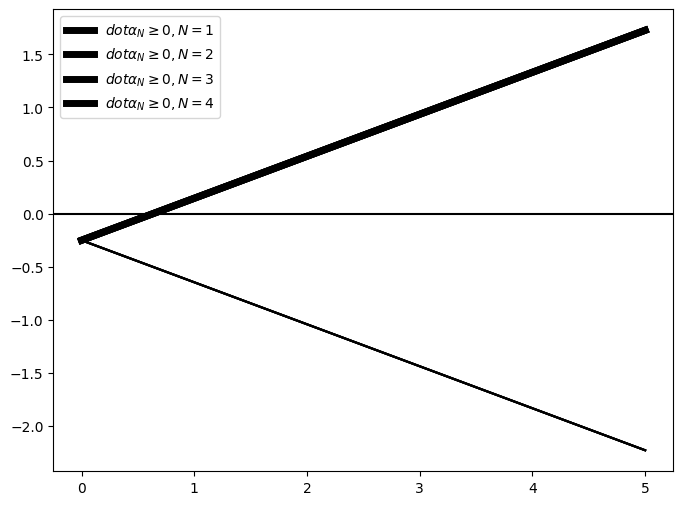

In [51]:
N = sp.symbols("N")
t = sp.symbols('t')
_a = sp.Function('a')
_w = sp.Function('w')
γ = sp.symbols('γ')
E0, L, w1, σc = sp.symbols('E0 L w1 σc')
β = sp.symbols('β')


fig, ax = plt.subplots(1, 1, figsize=(8, 6))


for _N in range(1, 5):
    u = sp.symbols([f"u{i}" for i in range(0, _N)])
    e = sp.symbols([f"e{i}" for i in range(1, _N+1)])
    α = sp.symbols([f"α{i}" for i in range(1, _N+1)])
    _α = sp.symbols("α")


    state = {"u": u, "α": α, "e": e}
    # _matpar = {N: _N, γ: 2, E0: 1, w1: 1, L: 1}
    _matpar.update({N: _N})
    # matpar = {"N": N, "γ": γ, "E0": E0, "w1": w1, "L": L}
    _loads = np.linspace(0., float(γ.subs(_matpar)), 30)

    atls = SymbolicDiscreteDamage(state, matpar)
    model = ModelAnalysis(atls)
    idx = model.positive_solution_wrt_t(_matpar)

    print(_matpar)
    evos = [evo.subs(_matpar) for evo in model.homogeneous_α(_matpar)]
    evo_x = evos[idx].subs(_matpar)

    for alphas in evos:
        _f = sp.lambdify(t, alphas.subs(_matpar_range), 'numpy')
        plt.plot(_loads, _f(_loads), c='k')

    _f = sp.lambdify(t, evo_x, 'numpy')
    ax.plot(_loads, _f(_loads), c='k', lw=5, label=f"$dot \\alpha_N \geq 0, N={_N}$")


ax.axhline(0, c='k')
ax.legend()
    

Text(0.5, 0, 't')

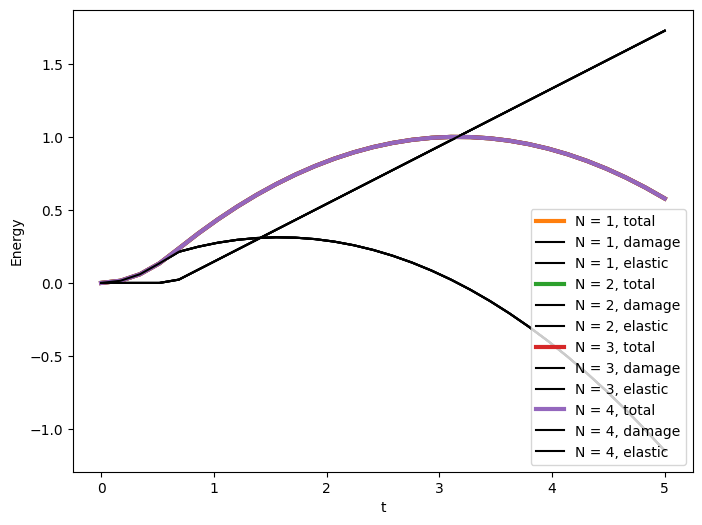

In [52]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

for _N in range(1, 5):
    u = sp.symbols([f"u{i}" for i in range(0, _N)])
    e = sp.symbols([f"e{i}" for i in range(1, _N+1)])
    α = sp.symbols([f"α{i}" for i in range(1, _N+1)])
    _α = sp.symbols("α")


    state = {"u": u, "α": α, "e": e}
    _matpar.update({N: _N})
    _loads = np.linspace(0., float(γ.subs(_matpar)), 30)

    atls = SymbolicDiscreteDamage(state, matpar)
    model = ModelAnalysis(atls)

    subs_homog_α, subs_homog_e =  model._state_homog_substitutions(state)
    alpha = model.homogeneous_damage(state, _matpar)

    _en = model.energy_fc_alpha().subs(subs_homog_α)    \
                .subs(_matpar) \
                .replace(_a, model.model.a) \
                .replace(sp.Function('s'), atls.s)      \
                .replace(_w, model.model.w)  \
                .subs(_matpar)          \
        .subs({sp.symbols('α_t'): alpha})

    _energy_damage = model.model._damage(state).subs(subs_homog_α).subs(_matpar) \
                .replace(_w, model.model.w)  \
                .subs({sp.symbols('α_t'): alpha})

    _f = sp.lambdify(t, _en.subs(_matpar), 'numpy')
    _f1 = sp.lambdify(t, _energy_damage, 'numpy')
    ax.plot(_loads, _f(_loads), label=f'N = {_N}, total', lw=3, c='C'+str(_N))
    ax.plot(_loads, _f1(_loads), c='k', label=f'N = {_N}, damage')
    ax.plot(_loads, _f(_loads)-_f1(_loads), c='k', label=f'N = {_N}, elastic')

ax.legend()
ax.set_ylabel('Energy')
ax.set_xlabel('t')
# plt.savefig(os.path.join(output_dir, 'Energy-homogeneous_damage-crit.png'))

### Plots of homogeneous response

In [686]:
_matpar = {N: 2, γ: 2, E0: 1, w1: 1, L: 1}

# _matpar[N]
model.get_state(_matpar)

{'u': [u0, u1], 'α': [α1, α2], 'e': [e1, e2]}

In [687]:
subs_homog_α, subs_homog_e =  model._state_homog_substitutions(state)

# Substitutions to compute homogeneous solutions
subs_homog_α, subs_homog_e

({α1: α_t, α2: α_t}, {e1: e_t, e2: e_t})

In [688]:
evos = [evo.subs(_matpar) for evo in model.homogeneous_α(_matpar)]
idx = model.positive_solution_wrt_t(_matpar)

evos[idx].subs(_matpar)

0.707106781186548*sqrt(2)*t - 1.0

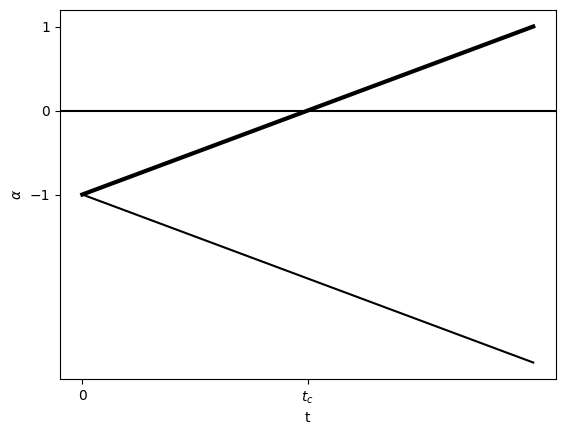

In [689]:
evos = [evo.subs(_matpar) for evo in model.homogeneous_α(_matpar)]
_loads = np.linspace(0., float(γ.subs(_matpar)), 30)
evo_x = evos[idx].subs(_matpar)

for alphas in evos:
    _f = sp.lambdify(t, alphas.subs(_matpar), 'numpy')
    plt.plot(_loads, _f(_loads), c='k')

_f = sp.lambdify(t, evo_x, 'numpy')
plt.plot(_loads, _f(_loads), c='k', lw=3)

plt.xlabel('t')
plt.ylabel('$\\alpha$')
plt.xticks([0, 1], ['0', '$t_c$'])
plt.yticks([-1, 0, 1])
plt.axhline(0, c='k')
plt.savefig('homogeneous_damage-crit.png')

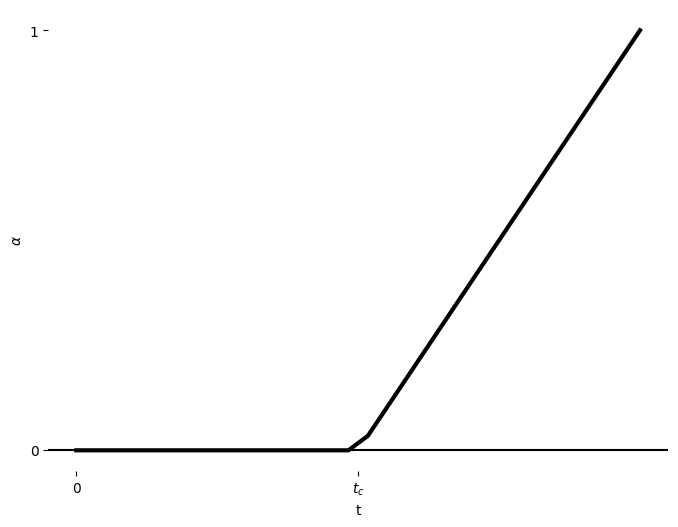

In [690]:
alpha = model.homogeneous_damage(state, _matpar)
figure, axis = plt.subplots(1, 1, figsize=(8, 6))

_f = sp.lambdify(t, alpha.subs(_matpar), 'numpy')
axis.plot(_loads, _f(_loads), c='k', lw=3)

plt.axhline(0, c='k')
plt.xlabel('t')
plt.ylabel('$\\alpha$')
plt.xticks([0, 1], ['0', '$t_c$'])
plt.yticks([0, 1])

for key, spine in axis.spines.items():
    spine.set_visible(False)
    
    
plt.savefig(os.path.join(output_dir, 'homogeneous_damage-crit.png'))

In [691]:
_en = model.energy_fc_alpha().subs(subs_homog_α)    \
            .subs(_matpar) \
            .replace(_a, model.model.a) \
            .replace(sp.Function('s'), atls.s)      \
            .replace(_w, model.model.w)  \
            .subs(_matpar)
_en

0.25*(1 - α_t)*(2.0*t**2 + 4.0*α_t*(α_t + 1)/(1 - α_t))/(α_t + 1)

In [692]:
_matpar

{N: 2, γ: 2, E0: 1, w1: 1, L: 1}

In [1003]:
model.energy_fc_alpha()

TypeError: 'Add' object is not callable

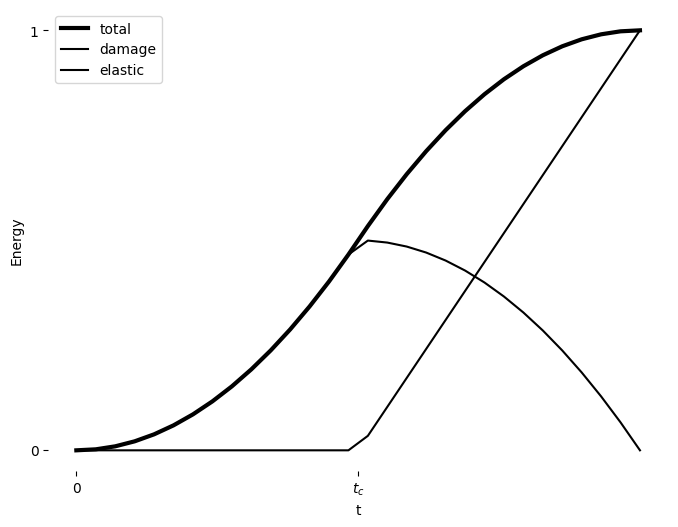

In [693]:
_en = model.energy_fc_alpha().subs(subs_homog_α)    \
            .subs(_matpar) \
            .replace(_a, model.model.a) \
            .replace(sp.Function('s'), atls.s)      \
            .replace(_w, model.model.w)  \
            .subs(_matpar)          \
    .subs({sp.symbols('α_t'): alpha})

_energy_damage = model.model._damage(state).subs(subs_homog_α).subs(_matpar) \
            .replace(_w, model.model.w)  \
            .subs({sp.symbols('α_t'): alpha})

_f = sp.lambdify(t, _en.subs(_matpar), 'numpy')
_f1 = sp.lambdify(t, _energy_damage, 'numpy')
figure, axis = plt.subplots(1, 1, figsize=(8, 6))

axis.plot(_loads, _f(_loads), c='k', label='total', lw=3)
axis.plot(_loads, _f1(_loads), c='k', label='damage')
axis.plot(_loads, _f(_loads)-_f1(_loads), c='k', label='elastic')

axis.legend()
plt.ylabel('Energy')
plt.xlabel('t')
plt.xticks([0, 1], ['0', '$t_c$'])
plt.yticks([0, 1])

for key, spine in axis.spines.items():
    spine.set_visible(False)

plt.savefig(os.path.join(output_dir, 'Energy-homogeneous_damage-crit.png'))

_en_homogeneous_t = _f


### Bifurcations

Compute bifurcated solutions with $m$ damaging springs out of the available $N$, with $m<N$

In [694]:
_matpar

{N: 2, γ: 2, E0: 1, w1: 1, L: 1}

In [695]:
atls = SymbolicDiscreteDamage(state, matpar)
model = ModelAnalysis(atls)
model.criterion().subs(_matpar)

0.25*t**2*Subs(Derivative(a(β), β), β, 0) + Subs(Derivative(w(β), β), β, 0)/2

In [696]:
model.criterion().simplify()

(1.0*E0*t**2*Subs(Derivative(a(β), β), β, 0) + 2*L**2*w1*Subs(Derivative(w(β), β), β, 0))/(L**2*N**2)

In [697]:
# we bifurcate m springs

m = 1

assert m < _matpar[N]

In [698]:
bif_α, homo_α, bif_e, homo_e = model._state_split(m, state, _matpar)
print(f'set of bifurcated (evolving) springs {bif_α}')
print(f'set of stationary springs {homo_α}')

set of bifurcated (evolving) springs [α2]
set of stationary springs {α1}


In [699]:
subs_bif_α, subs_bif_e =  model._state_bifurcation_substitutions(m, state, _matpar)

In [700]:
# substitutions for damage and strain
subs_bif_α, subs_bif_e

({α2: α_t, α1: α^*}, {e2: e_t, e1: e^*})

In [701]:
model._elastic_energy_fc_alpha()

0.5*E0*N*t**2/(L**2*(s(α1) + s(α2)))

In [707]:
_elastic_en_bif_alpha = model._elastic_energy_fc_alpha().subs(subs_bif_α)
_elastic_en_bif_alpha

0.5*E0*N*t**2/(L**2*(s(α^*) + s(α_t)))

In [708]:
_en_bif_ = sp.diff(_elastic_en_bif_alpha.subs({sp.symbols('α^*'): 0}), sp.symbols('α_t'))

-0.5*E0*N*t**2*Derivative(s(α_t), α_t)/(L**2*(s(0) + s(α_t))**2)

In [828]:
_diff_en_bif_m = sp.diff(model.energy_m_bifurcations(sp.symbols('m')), sp.symbols('α_t'))    \
    .replace(sp.Function('s'), atls.s) \
    .replace(sp.Function('w'), atls.w) \
    .subs({sp.symbols('α^*'): 0})       \
    .subs(_matpar).doit()
    # .subs(sp.symbols('m'), m)
    
_diff_en_bif_m

-0.5*m*t**2*(1.0/(1 - α_t) + 1.0*(α_t + 1)/(1 - α_t)**2)/(-0.5*m + 0.5*m*(α_t + 1)/(1 - α_t) + 1)**2 + m

In [836]:
_diff_en_bif_m.subs(sp.symbols('m'), m).simplify()

1.0 - 1.0*t**2

In [834]:
sp.solve(
    _diff_en_bif_m.subs(sp.symbols('m'), m),
    sp.symbols('α_t'))
    

[]

In [832]:
m, _matpar[N]

(1, 2)

In [493]:
def _elastic_energy_m_bifurcations(m, state):
    n = len(state["α"])
    # n = N
    N = sp.symbols('N')
    # _s = model.model.s
    _s = sp.Function('s')
    
    at = sp.symbols('α_t')
    ax = sp.symbols('α^*')
    return 1./2. * E0 * (N * t / L)**2 * 1 / ((N-m)*_s(ax) + m*_s(at))
    

def _diff_energy_m_bifurcations(m, state):
    n = len(state["α"])
    n = N
    # _s = model.model.s
    _s = sp.Function('s')
    
    at = sp.symbols('α_t')
    ax = sp.symbols('α^*')
    return - 1./2. * E0 * (N * t / L)**2 * m * sp.diff(_s(at), at) / ((n-m)*_s(ax) + m*_s(at))**2
    
    
def energy_m_bifurcations(m, state):
    n = len(state["α"])
    at = sp.symbols('α_t')
    ax = sp.symbols('α^*')
    
    return _elastic_energy_m_bifurcations(m, state) +   \
        model.matpar["w1"] * (m * model.model.w(at) + (n-m) * model.model.w(ax))

def xi_elastic_energy_m_bifurcations(m, state):
    n = len(state["α"])
    # n = N
    N = sp.symbols('N')
    # _s = model.model.s
    _s = sp.Function('s')
    
    at = sp.symbols('α_t')
    ax = sp.symbols('α^*')
    xi = m/N
    xi = sp.symbols('xi')
    return 1./2. * E0 * (t / L)**2 * 1 / (_s(ax) + (xi)*(_s(at)-_s(ax)))
    
def xi_energy_m_bifurcations(m, state):
    n = len(state["α"])
    at = sp.symbols('α_t')
    ax = sp.symbols('α^*')
    N = sp.symbols('N')
    xi = m/N
    xi = sp.symbols('xi')
    return xi_elastic_energy_m_bifurcations(m, state) +   \
        model.matpar["w1"] * (xi * model.model.w(at) + (1-xi) * model.model.w(ax))

def xi_diff_energy_m_bifurcations(m, state):
    n = len(state["α"])
    n = N
    # _s = model.model.s
    _s = sp.Function('s')
    
    at = sp.symbols('α_t')
    ax = sp.symbols('α^*')
    xi = sp.symbols('xi')
    return - 1./2. * E0 * (t / L)**2 * xi * sp.diff(_s(at), at) / ((_s(ax) + (xi)*(_s(at)-_s(ax))))**2 + \
        model.matpar["w1"] * (xi * sp.diff(model.model.w(at), at) ) 
    
    
_diff_energy_m_bifurcations(sp.symbols('m'), state)

-0.5*E0*N**2*m*t**2*Derivative(s(α_t), α_t)/(L**2*(m*s(α_t) + (N - m)*s(α^*))**2)

In [809]:
model.xi_elastic_energy_m_bifurcations()

0.5*E0*t**2/(L**2*(xi*(-s(α^*) + s(α_t)) + s(α^*)))

In [710]:
model.xi_energy_m_bifurcations()


0.5*E0*t**2/(L**2*(xi*(-s(α^*) + s(α_t)) + s(α^*))) + w1*(xi*α_t + α^**(1 - xi))

In [711]:
model.xi_diff_energy_m_bifurcations()


-0.5*E0*t**2*xi*Derivative(s(α_t), α_t)/(L**2*(xi*(-s(α^*) + s(α_t)) + s(α^*))**2) + w1*xi

#### Function of m bifurcated branches

In [715]:
model.energy_m_bifurcations(sp.symbols('m'))

0.5*E0*N**2*t**2/(L**2*(m*s(α_t) + (N - m)*s(α^*))) + w1*(m*α_t + α^**(2 - m))

In [716]:
model._elastic_energy_m_bifurcations(sp.symbols('m'))


0.5*E0*N**2*t**2/(L**2*(m*s(α_t) + (N - m)*s(α^*)))

In [717]:
sp.diff(
    _elastic_energy_m_bifurcations(sp.symbols('m'), state), 
    sp.symbols('α_t'))


-0.5*E0*N**2*m*t**2*Derivative(s(α_t), α_t)/(L**2*(m*s(α_t) + (N - m)*s(α^*))**2)

In [718]:
sp.diff(
    energy_m_bifurcations(sp.symbols('m'), state), 
    sp.symbols('α_t'))

-0.5*E0*N**2*m*t**2*Derivative(s(α_t), α_t)/(L**2*(m*s(α_t) + (N - m)*s(α^*))**2) + m*w1

In [719]:
sp.diff(
    energy_m_bifurcations(sp.symbols('m'), state)
        .subs({sp.symbols('α^*'): 0}), 
    sp.symbols('α_t'))

-0.5*E0*N**2*m*t**2*Derivative(s(α_t), α_t)/(L**2*(m*s(α_t) + (N - m)*s(0))**2) + m*w1

In [721]:
bif_crit_m = sp.diff(
    model.energy_m_bifurcations(sp.symbols('m')).subs({sp.symbols('α^*'): 0}) \
    , sp.symbols('α_t'))                        \
        .replace(sp.Function('s'), atls.s)      \
        .replace(_w, model.model.w)             \
        .simplify()

bif_crit_m

-0.5*E0*N**2*m*t**2*(α_t - 1)**2*(1.0*α_t*γ/(α_t - 1)**2 - 1.0*α_t/(α_t - 1)**2 - 1.0*γ/(α_t - 1) + 1.0/(α_t - 1) + 1.0/(α_t - 1)**2)/(L**2*(-N*α_t + N + m*α_t*γ)**2) + 1.0*m*w1

In [722]:
sp.diff(
    model._elastic_energy_m_bifurcations(sp.symbols('m')).subs({sp.symbols('α^*'): 0}) 
    , sp.symbols('α_t'))   \
.replace(sp.Function('s'), atls.s) \
.replace(_w, model.model.w) \
.doit()
# .simplify()

-0.5*E0*N**2*m*t**2*(1.0*(γ - 1)/(1 - α_t) + 1.0*(α_t*(γ - 1) + 1)/(1 - α_t)**2)/(L**2*(1.0*N - 1.0*m + 1.0*m*(α_t*(γ - 1) + 1)/(1 - α_t))**2)

In [723]:
model.xi_elastic_energy_m_bifurcations()

0.5*E0*t**2/(L**2*(xi*(-s(α^*) + s(α_t)) + s(α^*)))

In [736]:
model.criterion()

(1.0*E0*t**2*Subs(Derivative(a(β), β), β, 0)/(L**2*N) + 2*w1*Subs(Derivative(w(β), β), β, 0)/N)/N

In [737]:
atls.a(0)

(1 - w(0))/((γ - 1)*w(0) + 1)

In [743]:
model._ap.replace(sp.Function('a'), atls.a) \
    .replace(sp.Function('w'), atls.w) \
    .doit()

(1 - β)*(1 - γ)/(β*(γ - 1) + 1)**2 - 1/(β*(γ - 1) + 1)

In [746]:
sp.diff(model.model.a(sp.symbols('α')), sp.symbols('α')) \
    .replace(sp.Function('a'), atls.a) \
    .replace(sp.Function('w'), atls.w) \
    .doit()

-(1 - α)*(γ - 1)/(α*(γ - 1) + 1)**2 - 1/(α*(γ - 1) + 1)

In [760]:
atls.aprime().subs({sp.symbols('α'): 0})

-γ

In [761]:
atls.wprime().subs({sp.symbols('α'): 0})

1

In [779]:
_normalise = {E0: 1, w1: 1, L: 1}

In [780]:
 model.xi_diff_energy_m_bifurcations().subs(_normalise)

-0.5*t**2*xi*Derivative(s(α_t), α_t)/(xi*(-s(α^*) + s(α_t)) + s(α^*))**2 + xi

In [785]:
bif_crit_m = model.xi_diff_energy_m_bifurcations().subs(_normalise) \
    .subs({sp.symbols('α^*'): 0}) \
    .replace(sp.Function('s'), atls.s)      \
    .replace(_w, model.model.w)             \
    .subs(_matpar) \
    .simplify()
    
bif_crit_m

-0.125*t**2*xi*(α_t - 1)**2*(1.0*α_t/(α_t - 1)**2 - 1.0/(α_t - 1) + 1.0/(α_t - 1)**2)/(xi*α_t - 0.5*α_t + 0.5)**2 + xi

In [799]:
sp.solve(bif_crit_m, sp.symbols('α_t'))[1]

(t - 1.0)/(2.0*xi - 1.0)

3.0*t + 3.0
3.0 - 3.0*t
-1.66666666666667*t - 1.66666666666667
1.66666666666667*t - 1.66666666666667
-1.25*t - 1.25
1.25*t - 1.25
-1.0*t - 1.0
1.0*t - 1.0


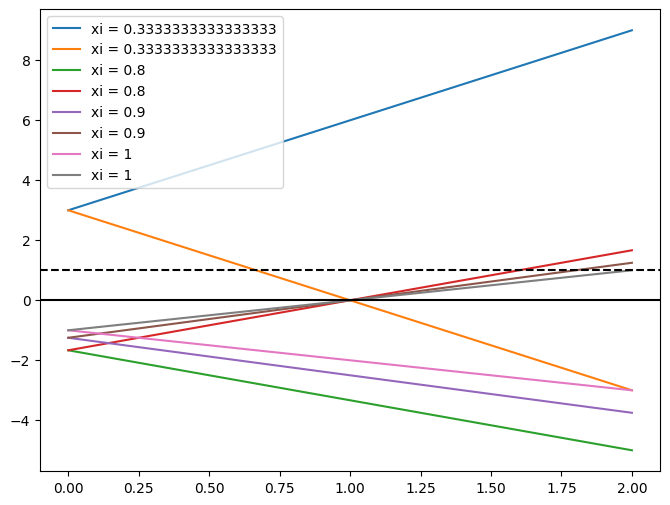

In [840]:
_evo_alpha_t = sp.solve(bif_crit_m, sp.symbols('α_t'))
_loads = np.linspace(0., _matpar[γ], 30)
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
for xi in [1/3, 4/5, 9/10, 1]:
    for evo in _evo_alpha_t:
        _f = sp.lambdify(t, evo.subs(sp.symbols('xi'), xi), 'numpy')
        ax.plot(_loads, _f(_loads), label=f'xi = {xi}')
        # _evo_alpha_t.subs(sp.symbols('xi'), xi)
        print(evo.subs(sp.symbols('xi'), xi))
plt.legend()
ax.axhline(0, c='k')
ax.axhline(1, c='k', ls='--')
# _f = sp.lambdify(t, _evo_alpha_t.subs(sp.symbols('xi'), xi), 'numpy')
# plt.plot(_loads, _f(_loads), label=f'xi = {xi}')
    

In [787]:
bif_crit_m.simplify()

-0.25*t**2*xi/(xi*α_t - 0.5*α_t + 0.5)**2 + xi

In [788]:
bif_crit_m.args[1].simplify()

-0.25*t**2*xi/(xi*α_t - 0.5*α_t + 0.5)**2

In [789]:
num, den = sp.fraction(bif_crit_m.args[1].simplify())

In [790]:
den.factor(sp.symbols('α_t')) 

1.0*(α_t*(1.0*xi - 0.5) + 0.5)**2

In [791]:
sp.latex(den.factor(sp.symbols('α_t')) )

'1.0 \\left(α_{t} \\left(1.0 \\xi - 0.5\\right) + 0.5\\right)^{2}'

In [792]:
# sp.latex(
sp.solve(bif_crit_m, sp.symbols('α_t'))[1].simplify().subs(_matpar)
# )

(t - 1.0)/(2.0*xi - 1.0)

In [793]:
xi_energy_m_bifurcations(sp.symbols('xi'), state)

0.5*E0*t**2/(L**2*(xi*(-s(α^*) + s(α_t)) + s(α^*))) + w1*(xi*α_t + α^**(1 - xi))

In [794]:
xi_diff_energy_m_bifurcations(sp.symbols('m'), state)

-0.5*E0*t**2*xi*Derivative(s(α_t), α_t)/(L**2*(xi*(-s(α^*) + s(α_t)) + s(α^*))**2) + w1*xi

In [795]:
xi_diff_energy_m_bifurcations(sp.symbols('m'), state) \
    .subs({sp.symbols('α^*'): 0}).replace(sp.Function('s'), atls.s)      \
    .replace(_w, model.model.w).doit()
    # .subs({sp.symbols('xi'): 1})         \
    # .factor(sp.symbols('xi'))



-0.5*E0*t**2*xi*(1.0*(γ - 1)/(1 - α_t) + 1.0*(α_t*(γ - 1) + 1)/(1 - α_t)**2)/(L**2*(xi*(-1.0 + 1.0*(α_t*(γ - 1) + 1)/(1 - α_t)) + 1.0)**2) + w1*xi

In [796]:
bif_crit_xi = sp.diff(
    xi_energy_m_bifurcations(sp.symbols('xi'), state)   \
    .subs({sp.symbols('α^*'): 0}) \
        , sp.symbols('α_t'))    \
        .replace(sp.Function('s'), atls.s)      \
        .replace(_w, model.model.w)         \
        .simplify()

bif_crit_xi

-0.5*E0*t**2*xi*(α_t - 1)**2*(1.0*α_t*γ/(α_t - 1)**2 - 1.0*α_t/(α_t - 1)**2 - 1.0*γ/(α_t - 1) + 1.0/(α_t - 1) + 1.0/(α_t - 1)**2)/(L**2*(xi*α_t*γ - α_t + 1)**2) + 1.0*w1*xi

In [498]:
bif_crit_xi = bif_crit_xi.args[1].simplify()+bif_crit_xi.args[0]

In [523]:
bif_crit_xi

-0.5*E0*t**2*xi*γ/(L**2*(xi*α_t*γ - α_t + 1)**2) + 1.0*w1*xi

In [526]:
sp.latex(bif_crit_xi, mode='plain')

'- \\frac{0.5 E_{0} t^{2} \\xi γ}{L^{2} \\left(\\xi α_{t} γ - α_{t} + 1\\right)^{2}} + 1.0 w_{1} \\xi'

In [500]:
bif_xi_solutions = sp.solve(bif_crit_xi, sp.symbols('α_t'))
bif_xi_solutions

[(-L*w1 - 0.707106781186548*t*sqrt(E0*w1*γ))/(L*w1*(xi*γ - 1.0)),
 (-L*w1 + 0.707106781186548*t*sqrt(E0*w1*γ))/(L*w1*(xi*γ - 1.0))]

In [501]:
[sol.subs(_matpar) for sol in bif_xi_solutions]


[-3.53553390593274*sqrt(2)*t - 5.0, 3.53553390593274*sqrt(2)*t - 5.0]

In [502]:
def positive_solution_wrt_t(model, solutions, _matpar = {}):
    # print([sp.diff(sol, sp.symbols('t')).subs(_matpar) for sol in solutions])
    idx = np.where(np.array([sp.diff(sol, sp.symbols('t')).subs(_matpar) for sol in solutions]) > 0)
    return idx



In [503]:
[sp.diff(sol, sp.symbols('t')).subs(_matpar).subs({sp.symbols('xi'): .3}) for sol in bif_xi_solutions][0]

-3.53553390593274*sqrt(2)

In [504]:
_matpar.update({sp.symbols('xi'): .3})
_matpar

{N: 3, γ: 2, E0: 1, w1: 1, L: 1, xi: 0.3}

In [505]:
pos = positive_solution_wrt_t(model, bif_xi_solutions, _matpar)
pos[0]

array([0])

In [856]:
model.critical_load(_matpar)[0][0]

0.707106781186548*sqrt(2)

0.708523828844236*sqrt(2)*t + 1.00200400801603
0.911220078848644*sqrt(2)*t + 1.28865979381443
1.27636603102265*sqrt(2)*t + 1.80505415162455
2.12983970236912*sqrt(2)*t + 3.01204819277108
6.42824346533225*sqrt(2)*t + 9.09090909090909
6.31345340345131*sqrt(2)*t - 8.92857142857142
2.11708617121721*sqrt(2)*t - 2.9940119760479
1.27177478630674*sqrt(2)*t - 1.79856115107914
0.908877610779624*sqrt(2)*t - 1.2853470437018
0.707106781186548*sqrt(2)*t - 1.0


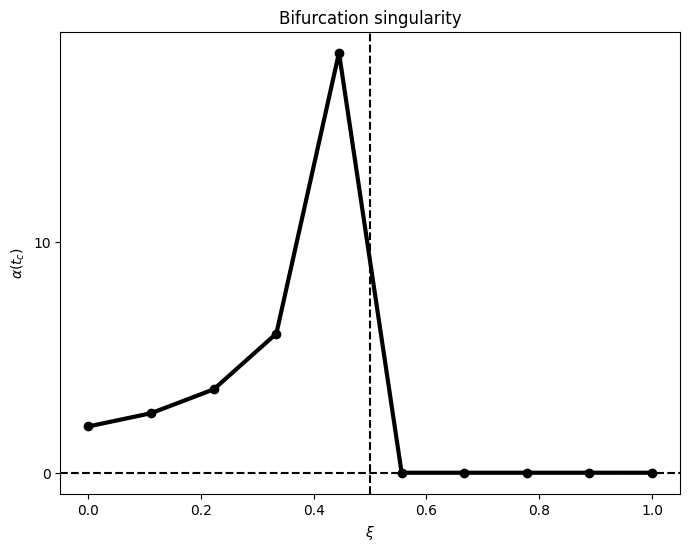

In [879]:
sols = sp.solve(bif_crit_xi, sp.symbols('α_t'))
_sequence = np.linspace(0.001, 1, 10)
tc = model.critical_load(_matpar)[0][0]

alpha_bif = []

# for _xi in [1/3, 1/4, 1/5, 2/5, 3/5, 9/10, 8/9, 4/5]:
for _xi in _sequence:
    _matpar.update({sp.symbols('xi'): _xi})
    # print(_matpar) 
    _sols = [sol.subs(_matpar) for sol in sols]
    pos = positive_solution_wrt_t(model, _sols, _matpar)
    idx = pos[0][0]
    print(_sols[idx].subs(sp.symbols('xi'), _xi))
    alpha_bif.append({'alpha(tc)': _sols[idx].subs(sp.symbols('xi'), _xi).subs(t, tc), 'xi': _xi})

alpha_bif

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot([a['xi'] for a in alpha_bif], [a['alpha(tc)'] for a in alpha_bif], marker='o', c='k', lw=3)
plt.title('Bifurcation singularity')
plt.xlabel('$\\xi$')
plt.ylabel('$\\alpha(t_c)$')
ax.set_yticks([0, 10])
# ax.set_xticks([0, 1, 1/3])
ax.axvline(1/2, c='k', ls='--')
ax.axhline(0, c='k', ls='--')
# plt.semilogy()
fig.savefig(os.path.join(output_dir, 'bifurcation-sing.png'))


[(-2.0*L*w1 - 1.4142135623731*t*sqrt(E0*w1*γ))/(2.0*L*w1*xi*γ - 2.0*L*w1), (-2.0*L*w1 + 1.4142135623731*t*sqrt(E0*w1*γ))/(2.0*L*w1*xi*γ - 2.0*L*w1)]


(-0.1, 3.1)

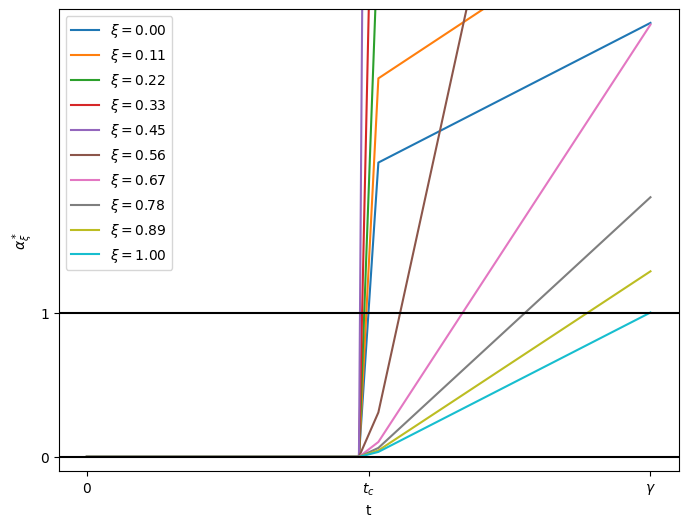

In [862]:
# sp.latex(
sols = sp.solve(bif_crit_xi, sp.symbols('α_t'))
_loads = np.linspace(0., float(γ.subs(_matpar)), 30)
print(sols), pos
tc = model.critical_load(_matpar)[0][0]

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

_sequence = np.linspace(0.001, 1, 10)

# for _xi in [1/3, 1/4, 1/5, 2/5, 3/5, 9/10, 8/9, 4/5]:
for _xi in _sequence:
    _matpar.update({sp.symbols('xi'): _xi})
    # print(_matpar) 
    _sols = [sol.subs(_matpar) for sol in sols]
    pos = positive_solution_wrt_t(model, _sols, _matpar)
    # print(pos[0][0])
    idx = pos[0][0]
    # for sol in _sols[idx]:
    # print(_sols[idx].subs(sp.symbols('xi'), _xi))
    bounded_sol = sp.Piecewise((_sols[idx], t >= tc), (0, t < tc))
    # _f = sp.lambdify(t, _sols[idx], 'numpy')
    _f = sp.lambdify(t, bounded_sol, 'numpy')
    plt.plot(_loads, _f(_loads), label=f'$\\xi = {_xi:.2f}$')
plt.axhline(0, c='k')
plt.axhline(1, c='k')
plt.legend()
plt.ylabel('$\\alpha_\\xi^*$')
plt.xlabel('t')
plt.xticks([0, 1, _matpar[γ]], ['0', '$t_c$', '$\\gamma$'])
plt.yticks([0, 1])
plt.ylim(-.1, 3.1)

fig.savefig(os.path.join(output_dir, 'bifurcation-sing.png'))


In [882]:
import seaborn as sns
palette = sns.color_palette("viridis", as_cmap=True)


In [892]:
!ls

__pycache__                    homogeneous_damage-crit.png
class_stability.ipynb          multifissa.ipynb
colab_discrete_stability.ipynb pacman-stability.ipynb
cone-stability.ipynb           pacman.ipynb
convergence.ipynb              plots.py
discrete-bar.ipynb             postprocess.py
discrete_bar-symbolic.ipynb    visuals.py
discrete_stability.ipynb


In [906]:
sp.Min(sp.Piecewise((_sols[idx], t >= tc), (0, t < tc)), 1)

Min(1, Piecewise((0.708523828844236*sqrt(2)*t + 1.00200400801603, t >= 0.707106781186548*sqrt(2)), (0, True)))

[(-2.0*L*w1 - 1.4142135623731*t*sqrt(E0*w1*γ))/(2.0*L*w1*xi*γ - 2.0*L*w1), (-2.0*L*w1 + 1.4142135623731*t*sqrt(E0*w1*γ))/(2.0*L*w1*xi*γ - 2.0*L*w1)]


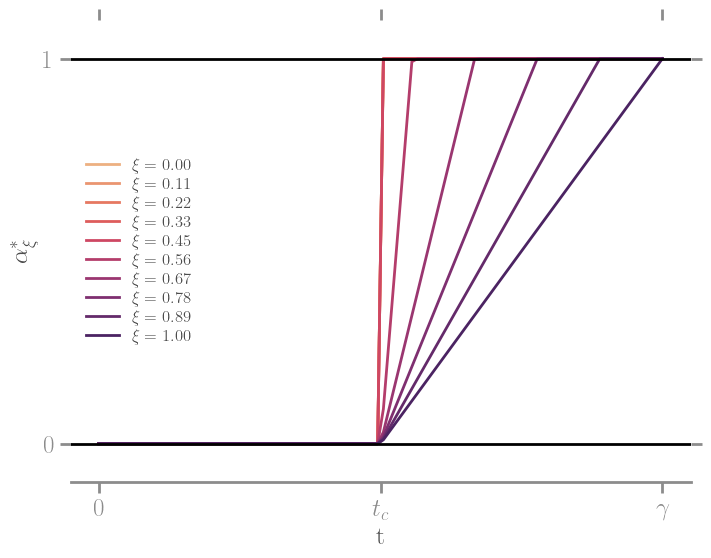

In [910]:
# sp.latex(

from visuals import *

matplotlibdefaults(palette='light',useTex=True)

sols = sp.solve(bif_crit_xi, sp.symbols('α_t'))
_loads = np.linspace(0., float(γ.subs(_matpar)), 100)
print(sols), pos
tc = model.critical_load(_matpar)[0][0]

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

_sequence = np.linspace(0.001, 1, 10)
palette = sns.color_palette("viridis", n_colors=10)
palette = sns.color_palette("Paired")
palette = sns.color_palette("rocket", as_cmap=True)
palette = sns.color_palette("flare", as_cmap=True)


for _xi in _sequence:
    _matpar.update({sp.symbols('xi'): _xi})
    _sols = [sol.subs(_matpar) for sol in sols]
    pos = positive_solution_wrt_t(model, _sols, _matpar)
    idx = pos[0][0]
    bounded_sol = sp.Piecewise((_sols[idx], t >= tc), (0, t < tc))
    # bounded_sol = sp.Min(sp.Piecewise((_sols[idx], t >= tc), (0, t < tc)), 1)
    _f = sp.lambdify(t, bounded_sol, 'numpy')
    # sns.lineplot(x=_loads, y=_f(_loads), label=f'$\\xi = {_xi:.2f}$', palette=palette)
    ax.plot(_loads, np.minimum(_f(_loads), 1), label=f'$\\xi = {_xi:.2f}$', color = palette(_xi))

plt.axhline(0, c='k')
plt.axhline(1, c='k')
plt.legend()
plt.ylabel('$\\alpha_\\xi^*$')
plt.xlabel('t')
plt.xticks([0, 1, _matpar[γ]], ['0', '$t_c$', '$\\gamma$'])
plt.yticks([0, 1])
plt.ylim(-.1, 1.1)
setspines0()
fig.savefig(os.path.join(output_dir, 'bifurcation-by-xi.png'))


In [198]:
bif_m_solutions = sp.solve(bif_crit_m, sp.symbols('α_t'))
# bif_m_solutions[1]

bif_m_solutions

[(-3.0*t - 3.0)/(2.0*m - 3.0), (3.0*t - 3.0)/(2.0*m - 3.0)]

In [208]:
model.model._damage(state).subs(subs_bif_α).subs({sp.symbols('α_t'): 0})   \
            .subs(_matpar) \
            .replace(_w, model.model.w)  \
            .replace(sp.symbols("a^*"), alpha)
            # .subs({sp.symbols('β'): alpha})


2*α^*/3

Text(0.5, 0, 't')

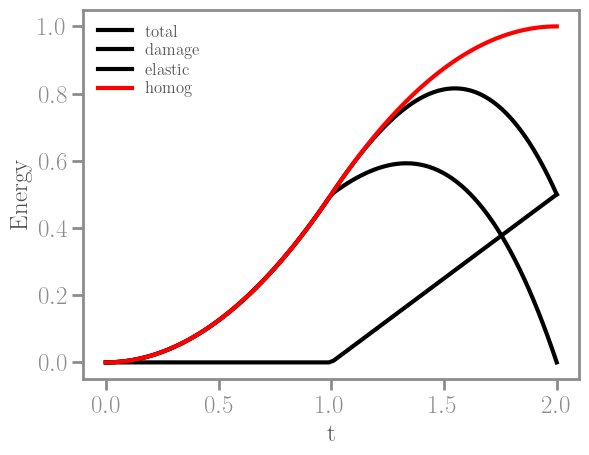

In [914]:
_en_alpha_bif = model.energy_fc_alpha().subs(subs_bif_α)    \
            .subs({sp.symbols('α_t'): 0})   \
            .replace(_a, model.model.a) \
            .replace(sp.Function('s'), atls.s)      \
            .replace(_w, model.model.w)  \
            .subs(_matpar)          \
            .replace(sp.symbols("α^*"), alpha)

_energy_damage_bif = model.model._damage(state).subs(subs_bif_α).subs({sp.symbols('α_t'): 0})   \
            .subs(_matpar) \
            .replace(_w, model.model.w)  \
            .replace(sp.symbols("α^*"), alpha)
            # .subs({sp.symbols('β'): alpha})


_f = sp.lambdify(t, _en_alpha_bif, 'numpy')
_fd = sp.lambdify(t, _energy_damage_bif, 'numpy')
plt.plot(_loads, _f(_loads), c='k', label='total', lw=3)
plt.plot(_loads, _fd(_loads), c='k', label='damage', lw=3)
plt.plot(_loads, _f(_loads) - _fd(_loads), c='k', label='elastic', lw=3)

plt.plot(_loads, _en_homogeneous_t(_loads), c='r', label='homog', lw=3)

plt.legend()
plt.ylabel('Energy')
plt.xlabel('t')

Text(0.5, 0, 't')

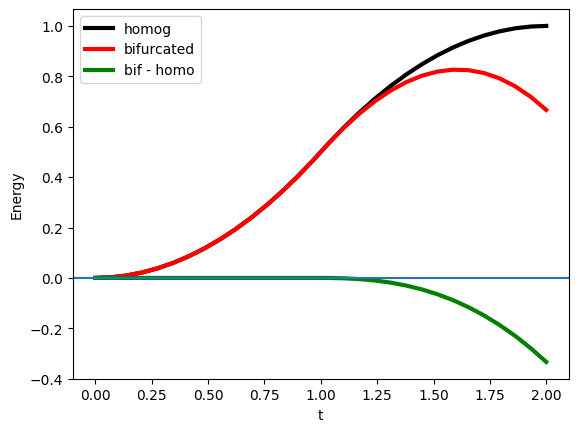

In [232]:
plt.plot(_loads, _en_homogeneous_t(_loads), c='k', label='homog', lw=3)
plt.plot(_loads, _f(_loads), c='r', label='bifurcated', lw=3)
# plt.plot(_loads, _en_homogeneous_t(_loads) - _f(_loads), c='k', label='total', lw=3)
# plt.plot(_loads, _en_homogeneous_t(_loads) - _fd(_loads), c='k', label='damage', lw=3)
plt.plot(_loads, _f(_loads) - _en_homogeneous_t(_loads), c='g', label='bif - homo', lw=3)
plt.axhline(0)
# plt.plot(_loads, , c='r', label='homog', lw=3)

plt.legend()
plt.ylabel('Energy')
plt.xlabel('t')

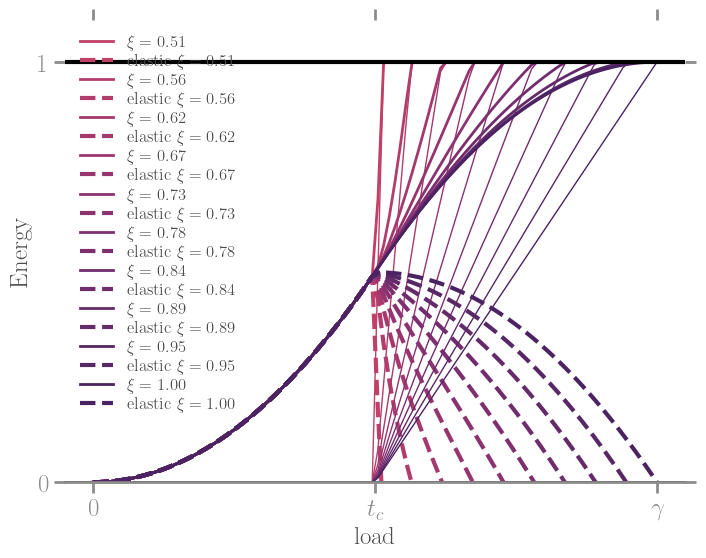

In [981]:
# Energy of bifurcated branches


sols = sp.solve(bif_crit_xi, sp.symbols('α_t'))
_loads = np.linspace(0., float(γ.subs(_matpar)), 100)
tc = model.critical_load(_matpar)[0][0]

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

_sequence = np.linspace(0.51, 1, 10)
# palette = sns.color_palette("viridis", n_colors=10)
# palette = sns.color_palette("Paired")
# palette = sns.color_palette("rocket", as_cmap=True)
# palette = sns.color_palette("flare", as_cmap=True)
    

for _xi in _sequence:
    _matpar.update({sp.symbols('xi'): _xi})
    _sols = [sol.subs(_matpar) for sol in sols]
    pos = positive_solution_wrt_t(model, _sols, _matpar)
    idx = pos[0][0]

    _total_xi_energy = model.xi_energy_m_bifurcations().subs(_normalise) \
        .subs({sp.Symbol('α^*'): 0})    \
        .replace(sp.Function('s'), atls.s)      \
        .replace(_w, model.model.w)         \
        .subs('xi', xi)                 \
        .subs(γ, _matpar[γ])


    _elastic_xi_energy = model.xi_elastic_energy_m_bifurcations().subs(_normalise) \
        .subs({sp.Symbol('α^*'): 0})    \
        .replace(sp.Function('s'), atls.s)      \
        .replace(_w, model.model.w)         \
        .subs('xi', xi)                 \
        .subs(γ, _matpar[γ])


            
    _total_xi_energy_alpha = sp.lambdify((t, sp.Symbol('α_t')), _total_xi_energy, 'numpy')
    _elastic_xi_energy_alpha = sp.lambdify((t, sp.Symbol('α_t')), _elastic_xi_energy, 'numpy')
    bounded_sol = sp.Piecewise((_sols[idx], t >= tc), (0, t < tc))
    _f = sp.lambdify(t, bounded_sol, 'numpy')
    alpha_t = _f(_loads)
    
    ax.plot(_loads, np.minimum(
            _total_xi_energy_alpha(_loads, alpha_t), 1), 
            label=f'$\\xi = {_xi:.2f}$', color = palette(_xi))    
    ax.plot(_loads, _elastic_xi_energy_alpha(_loads, alpha_t), 
            label=f'elastic $\\xi = {_xi:.2f}$', lw =3, color = palette(_xi), ls='--')
    ax.plot(_loads, np.minimum(
        _total_xi_energy_alpha(_loads, alpha_t) - _elastic_xi_energy_alpha(_loads, alpha_t),
        1), 
            lw =1, color = palette(_xi), ls='-')
plt.legend()
ax.set_ylabel('Energy')
ax.set_xlabel('load')
ax.set_xticks([0, 1, _matpar[γ]], ['0', '$t_c$', '$\\gamma$'])
ax.set_yticks([0, 1])
ax.axhline(0, c='k')
ax.set_ylim([0, 1.1])
ax.axhline(1, c='k', lw=3)
# model.xi_energy_m_bifurcations().subs(_normalise).subs({sp.symbols('α_*'): 0})
setspines0()
fig.savefig(os.path.join(output_dir, 'bifurcation-energy-xi.png'))


In [949]:
model.xi_energy_m_bifurcations().subs(_normalise) \
    .subs({sp.Symbol('α^*'): 0})    \
    .replace(sp.Function('s'), atls.s)      \
    .replace(_w, model.model.w)         \
    .subs(γ, _matpar[γ])             

# _total_xi_energy_alpha = 


0.5*t**2/(xi*(-1.0 + 1.0*(α_t + 1)/(1 - α_t)) + 1.0) + xi*α_t

In [923]:
_matpar

{N: 2, γ: 2, E0: 1, w1: 1, L: 1, xi: 1.0}

In [233]:
# The energy of the bifurcated system

_en_alpha_bifurcations = model.energy_fc_alpha().subs(subs_bif_α).subs({sp.symbols('α_t'): 0})
_en_alpha_bifurcations  \
            .replace(_a, model.model.a) \
            .replace(sp.Function('s'), model.model.s)      \
            # .replace(_w, model.model.w)  \
            # .subs(_matpar)          \
            

(0.5*E0*N**2*t**2 + L**2*w1*(2.0*((γ - 1)*w(α^*) + 1)/(1 - w(α^*)) + 1.0*((γ - 1)*w(0) + 1)/(1 - w(0)))*(w(0) + 2*w(α^*)))/(L**2*N*(2.0*((γ - 1)*w(α^*) + 1)/(1 - w(α^*)) + 1.0*((γ - 1)*w(0) + 1)/(1 - w(0))))

### Material behaviour

<lambdifygenerated-111>:2: RuntimeWarning: divide by zero encountered in scalar divide
  return 1.0*(α + 1)/(1 - α)
<lambdifygenerated-112>:2: RuntimeWarning: divide by zero encountered in scalar divide
  return 1.0/(1 - α) + 1.0*(α + 1)/(1 - α)**2
<lambdifygenerated-113>:2: RuntimeWarning: divide by zero encountered in scalar divide
  return 2.0*(1 - (α + 1)/(α - 1))/(α - 1)**2


(<Figure size 800x600 with 4 Axes>, array([<Axes: >, <Axes: >], dtype=object))

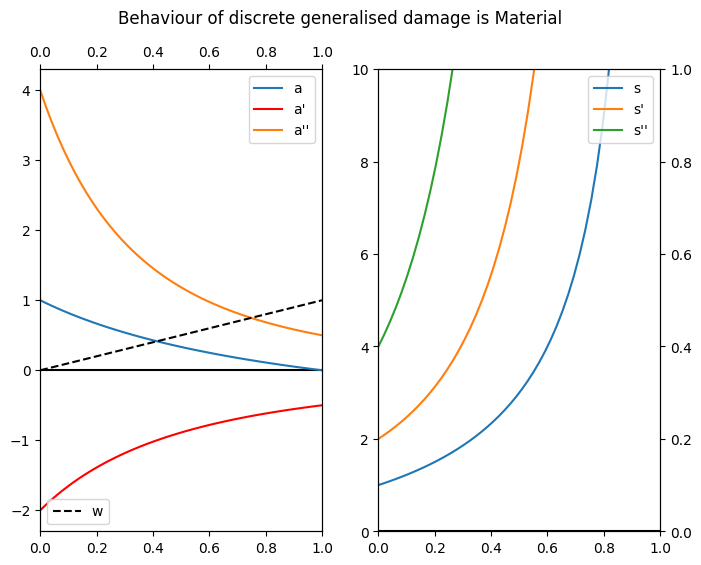

In [290]:
atls = SymbolicDiscreteDamage(state, matpar)
model = ModelAnalysis(atls)
(model.criterion()).subs(_matpar)

model.plot_material(_matpar)

In [227]:
(model.energy_fc_alpha().subs(subs_bif_α).subs({sp.symbols('α_t'): 0})).subs(_matpar)

2.0*t**2*a(0)*s(0)**2/(s(0) + s(a^*))**2 + 2.0*t**2*a(a^*)*s(a^*)**2/(s(0) + s(a^*))**2 + w(0) + w(a^*)

## Second variation

In [21]:
model.energy_fc_alpha()

(0.5*E0*N**2*t**2 + L**2*w1*(s(α1) + s(α2))*(w(α1) + w(α2)))/(L**2*N*(s(α1) + s(α2)))

In [983]:
def small_hessian(f_alpha, state):
    n = len(state["α"])
    
    
    return

In [22]:
small_hess = sp.hessian(model.energy_fc_alpha(), state["α"])
small_hess.simplify()

small_hess

Matrix([
[(-0.5*E0*N**2*t**2*s(α1)*Derivative(s(α1), (α1, 2)) - 0.5*E0*N**2*t**2*s(α2)*Derivative(s(α1), (α1, 2)) + 1.0*E0*N**2*t**2*Derivative(s(α1), α1)**2 + 1.0*L**2*w1*s(α1)**3*Derivative(w(α1), (α1, 2)) + 3.0*L**2*w1*s(α1)**2*s(α2)*Derivative(w(α1), (α1, 2)) + 3.0*L**2*w1*s(α1)*s(α2)**2*Derivative(w(α1), (α1, 2)) + 1.0*L**2*w1*s(α2)**3*Derivative(w(α1), (α1, 2)))/(L**2*N*(1.0*s(α1)**3 + 3.0*s(α1)**2*s(α2) + 3.0*s(α1)*s(α2)**2 + 1.0*s(α2)**3)),                                                                                                                                                                                                                                                                                                                  1.0*E0*N*t**2*Derivative(s(α1), α1)*Derivative(s(α2), α2)/(L**2*(1.0*s(α1)**3 + 3.0*s(α1)**2*s(α2) + 3.0*s(α1)*s(α2)**2 + 1.0*s(α2)**3))],
[                                                                                                      

In [37]:
num = sp.fraction(model.energy_fc_alpha())[0]
den = sp.fraction(model.energy_fc_alpha())[1]

num.args[0]/den+ num.args[1]/den

0.5*E0*N*t**2/(L**2*(s(α1) + s(α2))) + w1*(w(α1) + w(α2))/N

In [993]:
subs_inverse = {sp.Function('s')(sp.Symbol(a.name)): 1/_a(a) for a in state["α"]}
subs_inverse


{s(α1): 1/a(α1), s(α2): 1/a(α2)}

In [994]:
# subs_s_inverse = {sp.Function('s')(sp.Symbol(a.name)): 1/_a(a) for a in state["α"]}
subs_s_inverse = {sp.Function('a')(sp.Symbol(a.name)): 1/model.model._s(a) for a in state["α"]}
subs_s_inverse


{a(α1): 1/s(α1), a(α2): 1/s(α2)}

In [995]:
model.energy_fc_alpha().subs(subs_inverse)

(0.5*E0*N**2*t**2 + L**2*w1*(1/a(α2) + 1/a(α1))*(w(α1) + w(α2)))/(L**2*N*(1/a(α2) + 1/a(α1)))

In [996]:
model.energy_fc_alpha().subs(subs_s_inverse)

(0.5*E0*N**2*t**2 + L**2*w1*(s(α1) + s(α2))*(w(α1) + w(α2)))/(L**2*N*(s(α1) + s(α2)))

In [1002]:
model.energy_fc_alpha()

TypeError: 'Add' object is not callable

In [437]:
subs_stiffness = {_a(a): model.model.s(a) for a in state["α"]}
subs_stiffness

{a(α1): 1.0*((γ - 1)*w(α1) + 1)/(1 - w(α1)),
 a(α2): 1.0*((γ - 1)*w(α2) + 1)/(1 - w(α2))}

In [463]:
small_hess = sp.hessian(model.energy_fc_alpha().subs(subs_s_inverse), state["α"])
small_hess

Matrix([
[0.5*E0*N**2*t**2*Derivative(s(α1), (α1, 2))/(L**2*(s(α1) + s(α2))**2) - 1.0*E0*N**2*t**2*s(α1)*Derivative(s(α1), (α1, 2))/(L**2*(s(α1) + s(α2))**3) - 1.0*E0*N**2*t**2*s(α2)*Derivative(s(α1), (α1, 2))/(L**2*(s(α1) + s(α2))**3) - 2.0*E0*N**2*t**2*Derivative(s(α1), α1)**2/(L**2*(s(α1) + s(α2))**3) + 3.0*E0*N**2*t**2*s(α1)*Derivative(s(α1), α1)**2/(L**2*(s(α1) + s(α2))**4) + 3.0*E0*N**2*t**2*s(α2)*Derivative(s(α1), α1)**2/(L**2*(s(α1) + s(α2))**4) + w1*Derivative(w(α1), (α1, 2)),                                                                                                                                                                                                           -2.0*E0*N**2*t**2*Derivative(s(α1), α1)*Derivative(s(α2), α2)/(L**2*(s(α1) + s(α2))**3) + 3.0*E0*N**2*t**2*s(α1)*Derivative(s(α1), α1)*Derivative(s(α2), α2)/(L**2*(s(α1) + s(α2))**4) + 3.0*E0*N**2*t**2*s(α2)*Derivative(s(α1), α1)*Derivative(s(α2), α2)/(L**2*(s(α1) + s(α2))**4)],
[                          

In [465]:
model.energy_fc_alpha().subs(subs_s_inverse)

0.5*E0*N**2*t**2*s(α1)/(L**2*(s(α1) + s(α2))**2) + 0.5*E0*N**2*t**2*s(α2)/(L**2*(s(α1) + s(α2))**2) + w1*w(α1) + w1*w(α2)

In [998]:
small_hess[0, 0].simplify()

(-0.5*E0*N**2*t**2*s(α1)*Derivative(s(α1), (α1, 2)) - 0.5*E0*N**2*t**2*s(α2)*Derivative(s(α1), (α1, 2)) + 1.0*E0*N**2*t**2*Derivative(s(α1), α1)**2 + 1.0*L**2*w1*s(α1)**3*Derivative(w(α1), (α1, 2)) + 3.0*L**2*w1*s(α1)**2*s(α2)*Derivative(w(α1), (α1, 2)) + 3.0*L**2*w1*s(α1)*s(α2)**2*Derivative(w(α1), (α1, 2)) + 1.0*L**2*w1*s(α2)**3*Derivative(w(α1), (α1, 2)))/(L**2*N*(1.0*s(α1)**3 + 3.0*s(α1)**2*s(α2) + 3.0*s(α1)*s(α2)**2 + 1.0*s(α2)**3))

In [1000]:
_i = sp.symbols('i')
sum = sp.summation(_a(_i), (_i, 0, len(state["α"])))
sum

a(0) + a(1) + a(2)

In [999]:
model.energy_fc_alpha()

(0.5*E0*N**2*t**2 + L**2*w1*(s(α1) + s(α2))*(w(α1) + w(α2)))/(L**2*N*(s(α1) + s(α2)))

### Printouts

In [137]:
model = ModelAnalysis(atls)

# Damage criterion (local)

print(sp.latex(model.
         criterion().simplify()
        , mode='plain'))


\frac{1.5 E_{0} t^{2} \left. \frac{d}{d β} a{\left(β \right)} \right|_{\substack{ β=0 }} + 3 L^{2} w_{1} \left. \frac{d}{d β} w{\left(β \right)} \right|_{\substack{ β=0 }}}{L^{2} N^{2}}


In [139]:
# Elastic energy as a function of alpha
print(sp.latex(model._elastic_energy_fc_alpha().simplify()
        , mode='plain'))

\frac{0.5 E_{0} N t^{2}}{L^{2} \left(s{\left(α_{1} \right)} + s{\left(α_{2} \right)} + s{\left(α_{3} \right)}\right)}


In [142]:
# Total energy as a function of alpha, homogeneous

print(sp.latex(model.energy_fc_alpha().subs(subs_homog_α).simplify()
        , mode='plain'))

\frac{0.166666666666667 E_{0} N t^{2}}{L^{2} s{\left(α_{t} \right)}} + \frac{3 w_{1} w{\left(α_{t} \right)}}{N}


In [143]:
# Total energy as a function of alpha, homogeneous

print(sp.latex(model.energy_fc_alpha().subs(subs_homog_α).subs(_matpar).simplify()
        , mode='plain'))

\frac{0.5 t^{2}}{s{\left(α_{t} \right)}} + w{\left(α_{t} \right)}


In [ ]:
print(sp.latex(_, mode='plain', symbol_names={'α': 'x'}))

\frac{0.5 E_{0} N^{2} t^{2} + 9 L^{2} w_{1} s{\left(α_{t} \right)} w{\left(α_{t} \right)}}{3 L^{2} N s{\left(α_{t} \right)}}


In [ ]:
# Evolution equation for homogeneous damage

subs_homog_α, subs_homog_e =  model._state_homog_substitutions(state)
subs_homog_α, subs_homog_e

sp.diff(model.energy_fc_alpha()                \
            .subs(subs_homog_α)
            # .replace(sp.Function('s'), model.model.s)
            , 
            sp.symbols('α_t')
            ).simplify()


In [146]:
# Material functions

print(sp.latex(
    model.model.s(sp.symbols('α_t'))
    , mode='plain'))

\frac{1.0 \left(\left(γ - 1\right) w{\left(α_{t} \right)} + 1\right)}{1 - w{\left(α_{t} \right)}}
\frac{1 - w{\left(α_{t} \right)}}{\left(γ - 1\right) w{\left(α_{t} \right)} + 1}


In [147]:
print(sp.latex(
    model.model.w(sp.symbols('α_t'))
    , mode='plain'))

α_{t}


In [148]:
print(sp.latex(
    model.model.a(sp.symbols('α_t'))
    , mode='plain'))

\frac{1 - w{\left(α_{t} \right)}}{\left(γ - 1\right) w{\left(α_{t} \right)} + 1}


In [149]:
# Derivatives of material functions
print(sp.latex(
sp.diff(model.model.s(sp.symbols('α_t')), 
sp.symbols('α_t')).simplify().factor()
    , mode='plain'))

\frac{1.0 γ \frac{d}{d α_{t}} w{\left(α_{t} \right)}}{\left(1.0 w{\left(α_{t} \right)} - 1.0\right)^{2}}


In [150]:
# Homogeneous evo
print(sp.latex(
model.homogeneous_α(state)
    , mode='plain'))

\left[ \frac{- L w_{1} - 0.235702260395516 N t \sqrt{E_{0} w_{1} γ}}{L w_{1} \left(γ - 1.0\right)}, \  \frac{- L w_{1} + 0.235702260395516 N t \sqrt{E_{0} w_{1} γ}}{L w_{1} \left(γ - 1.0\right)}\right]


In [194]:
# Bifurcations
print(sp.latex(
bif_crit_m.simplify()
    , mode='plain'))

- \frac{0.5 E_{0} N^{2} m t^{2} γ}{L^{2} \left(- N α_{t} + N + m α_{t} γ\right)^{2}} + 1.0 m w_{1}


## Examples

In [103]:
_N = 3

_matpar = {N: _N, γ: 3, E0: 1, w1: 1, L: 1}
matpar = {"N": N, "γ": γ, "E0": E0, "w1": w1, "L": L}

u = sp.symbols([f"u{i}" for i in range(0, _N)])
e = sp.symbols([f"e{i}" for i in range(1, _N+1)])
α = sp.symbols([f"α{i}" for i in range(1, _N+1)])
_α = sp.symbols("α")
_loads = np.linspace(0., float(γ.subs(_matpar)), 30)

β = sp.symbols('β')

state = {"u": u, "α": α, "e": e}

atls = SymbolicDiscreteDamage(state, matpar)

model = ModelAnalysis(atls)
_N* model.criterion().simplify().subs(_matpar)  \
    .replace(sp.Function('a'), atls.a)      \
        .replace(sp.Function('w'), atls.w).doit() \
# model.evo_α(state)


-0.5*t**2*γ + 1

In [104]:
tc, criterion = model.critical_load(_matpar)


In [105]:
model.energy_fc_alpha()     \
    .replace(sp.Function('s'), atls.s)      \
        .replace(sp.Function('w'), atls.w)  \
            .subs(model._state_homog_substitutions(state)[0]).simplify()    \
                .subs(sp.symbols('N'), _N) \
        # .doit().simplify()
# .subs(subs_homog_α).subs(_matpar).simplify()

(-1.5*E0*t**2*(α_t - 1) + 3.0*L**2*w1*α_t*(α_t*(γ - 1) + 1))/(3*L**2*(α_t*(γ - 1) + 1))

In [106]:
num, den = sp.fraction(_)
_eq_alpha = num.args[0]/den+ num.args[1]/den

In [82]:
sp.solve(_eq_alpha, sp.symbols('α_t'))[1].simplify().subs({E0: 1, w1: 1, L: 1})

(0.25*t**2 + 0.707106781186548*sqrt(0.125*t**4 - t**2*γ + 0.5*t**2 + 0.5) - 0.5)/(γ - 1.0)

In [60]:
model.homogeneous_α(state, _matpar)


[-0.612372435695794*t - 0.5, 0.612372435695794*t - 0.5]

In [61]:
[evo.subs({t: _matpar[γ]}) for evo in model.homogeneous_α(state, _matpar)]

[-2.33711730708738, 1.33711730708738]

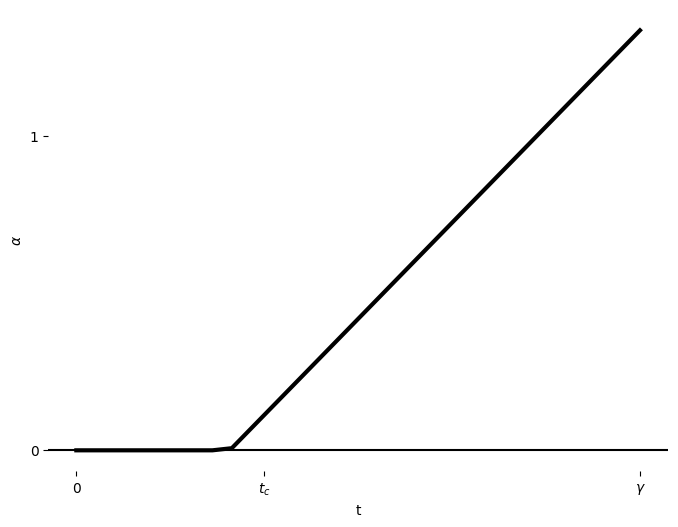

In [53]:
alpha = model.homogeneous_damage(state, _matpar)
figure, axis = plt.subplots(1, 1, figsize=(8, 6))

_f = sp.lambdify(t, alpha.subs(_matpar), 'numpy')
axis.plot(_loads, _f(_loads), c='k', lw=3)

plt.axhline(0, c='k')
plt.xlabel('t')
plt.ylabel('$\\alpha$')
plt.xticks([0, 1, _matpar[γ]], ['0', '$t_c$', '$\\gamma$'])
plt.yticks([0, 1])

for key, spine in axis.spines.items():
    spine.set_visible(False)
    
    
# plt.savefig(os.path.join(output_dir, 'homogeneous_damage-crit.png'))

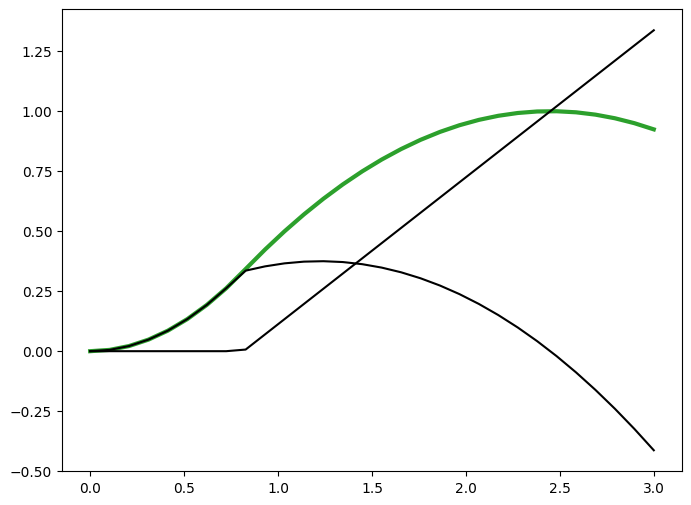

In [50]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

subs_homog_α, subs_homog_e =  model._state_homog_substitutions(state)
alpha = model.homogeneous_damage(state, _matpar)

_en = model.energy_fc_alpha().subs(subs_homog_α)    \
            .subs(_matpar) \
            .replace(_a, model.model.a) \
            .replace(sp.Function('s'), atls.s)      \
            .replace(_w, model.model.w)  \
            .subs(_matpar)          \
    .subs({sp.symbols('α_t'): alpha})

_energy_damage = model.model._damage(state).subs(subs_homog_α).subs(_matpar) \
            .replace(_w, model.model.w)  \
            .subs({sp.symbols('α_t'): alpha})

_f = sp.lambdify(t, _en.subs(_matpar), 'numpy')
_f1 = sp.lambdify(t, _energy_damage, 'numpy')
ax.plot(_loads, _f(_loads), label=f'N = {_N}, total', lw=3, c='C'+str(_N))
ax.plot(_loads, _f1(_loads), c='k', label=f'N = {_N}, damage')
ax.plot(_loads, _f(_loads)-_f1(_loads), c='k', label=f'N = {_N}, elastic')